# Analyzing Wages and its impact on Major League Baseball.
Purshottam Shivraj

DATA 512 Final Project

University of Washington, Fall 2018


## Introduction
MLB has been a popular sport that has attracted talented players and engrossed audiences over several decades however there has been a decline in its popularity over past few decades as mentioned in this article from [1][usatoday](https://www.usatoday.com/story/sports/mlb/2018/09/27/mlb-attendance-down-biggest-slide-decade/1441318002/) and the attendence dropped from 79 Million in 2008 to 69 million in 2018 as per [2][statistica](https://www.statista.com/statistics/193421/regular-season-attendance-in-the-mlb-since-2006/). More alarming is the decline in interest from particular community of people as highlighted by these post from [3][forbes](https://www.forbes.com/sites/leighsteinberg/2018/04/17/why-have-african-american-players-disappeared-in-mlb/#40befe2150df) 
and [4][Usnews](https://www.usnews.com/opinion/op-ed/articles/2017-07-10/3-reasons-for-the-declining-percentage-of-black-baseball-players-in-the-mlb) where the articles highlights decreasing number of representation of African-american in MLB and quotes this drop to be 18.7% in 1981 to 8.4% in year 2018 additionally emphasizing on overall decline in youth playing baseball.

However, it seems that bad weather and format of the game seems less interesting to people and this could potentially explain the drop in attendance for the game, however this doesn't explain the drop in representation of African-American players in MLB.
Stories and published works such as from [5][Fangraphs](https://www.fangraphs.com/tht/searching-for-racial-earnings-differentials-in-major-league-baseball/) around wages discrimination has pushed forward for the need to address this burning problem.
Though this has its implications on the sport as this would lead to underrepresentation from a community which once played and contributed to the growth of the beautiful sport and probably lesser revenue figures owing to less interest from similar audience group, however the bigger problem could be impact on future aspiring player who would like to play this sport and due to existence of disparity in wage structure might have to lookout for different opportunities.

In this analysis, I use the players wages, performance, States demographic distribution data and Race data to investigate the bias in wage distribution and highlight factors what affect wage distribution significantly.

## Research Questions

My research questions is around a persons race and his salary structure in MLB. There is ever increasing talks around steep drop in African-american players in MLB so I want to explore if disparity in wages is a reason for this decline. On a more Human centred context if such disparity exists this would potentially affect future/aspiring African-american youth/kids to play the beautiful game.

**RQ1: What are the most significant factors in determining a players wage in MLB.**

**RQ2: How consistently interpretable are these results across algorithms with similar perfromance.**


## Background (or Related Work)

This project is build on the data-set provided by work done as [6][Racial Salary Discrimination in Major League Baseball: A Closer Look](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ZUMXXL) where author analyzes the impact of Race as an exploratory variable using regression to infer impact of 3 variables Race, contract length and WAR(Wins Above Replacement) on Salary/wages. 

My understanding is that using just 3 variables based on my analysis of the data I was unable to get a stable cross-validation score for the data set, Hnece my approach takes a non-linear decision boundary contrary to linear decision boundary used by the author.Additional exploratory variables like: Postion played, State, Team played for, Age, Total games played, various perfromance metric and Ratio of white/non-white population of team's state of origin is used as exploratory variables to better explain the impact.

## Reproducibility

To make the results reproducible I have included all the steps required for data cleaning in this notebook and additionally provided initial setup for the workflow in the Readme.md. All the raw files are available in the repo's ```data``` folder alongside processed data files as well. Alongside this all the graphs/images are also shared in the ```image``` folder.

## Loading Libraries

In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# modeling libraries

from sklearn.model_selection import train_test_split
import lightgbm as lgb
import random
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})

## Data
The primary data for this analysis comes from Dataverse licensed under CC-BY-NC as zipped files from the above-mentioned link as dataverse_files.zip.

The dataverse_files.zip contains a zipped file called Original Data.zip which needs to be processed to generate final data: This contains primarily two datasets:

* Contract Data: These are present in the form of CSV files for each year 2012 till 2015. These are present as a set of files following the nomenclature: ```[year]_Contract_Data.csv```

* WAR Data: WAR is defined as Wins Above Replacement which means A single number that presents the number of wins the player added to the team above what a replacement player (think AAA or AAAA) would add. This definition is taken from Baseball Reference. These are present as a set of files following the nomenclature: ```IMPORTABLE_leagues_MLB_[year]-value-batting_players_value_batting.csv```

### Get contract data into single dataframe.

Since we have Contract Data split by years we will grab all contract files from the ```Original Data``` folder and concatenate to form a single data frame and creating additinal column called ```year```.
There are also some missing and garbage values which we will remove from the dataset to maintain consistency and help further anaysis. Final merged data frame will be saved to ```final_data``` folder as ```contract_data.csv```for future use.

In [3]:
# getting all contract xls files from the original data folder and appendig them.
contract_data = pd.DataFrame()
# using regex to get all contract data as they all start with dates 2012_*, 2013_* etc.
for file in glob.glob("Original Data/201*.xlsx"):
    data = pd.read_excel(file, dtype={'PLAYER':str, 'POS':str,'AGE':str, 'STATUS':str,'YRS':str, 'RK':str, 'DOLLARS':str})
    data['year'] = file[file.find("Original Data\\" ) +14 : file.find('_')]
    data = data.loc[:, ~data.columns.str.startswith('201')]
    contract_data = contract_data.append(data)
    
#cleaning data frame to remove unwanted and missing values. 
contract_data.columns = ['Players', 'POS', 'Age', 'Status', 'team', 'years_contract', 'rk', 'dollars', 'year']
new_df = contract_data[contract_data.Players != 'PLAYER']
new_df = new_df[new_df.team != '--']
new_df = new_df[(new_df.dollars != '--') & (new_df.dollars != 'DOLLARS') & (new_df.dollars != 'Minor Lg')]
new_df = new_df[(new_df.Age != 'AGE')]
new_df = new_df[new_df.notna()]

#convert datatypes for easier computation later.
for col in ['Age','dollars', 'years_contract', 'year']:
    new_df[col] = new_df[col].astype('int')
for col in ['Players','POS', 'Status', 'team', 'rk']:
    new_df[col] = new_df[col].astype('category')
# getting annual_income values using get ratio of total dollar amount to contract length.
new_df['annual_income'] = new_df['dollars']/new_df['years_contract']
new_df['annual_income'] = new_df['annual_income'].astype(float)
new_df.to_csv('final_data/contract_data.csv', index=False)
new_df.head()

,Players,POS,Age,Status,team,years_contract,rk,dollars,year,annual_income
1,Mike Adams,RP,38,Agreed,Phillies,2,39,12000000,2012,6000000.000
2,Jeremy Affeldt,RP,37,Signed,Giants,3,NR,18000000,2012,6000000.000
4,Scott Baker,SP,35,Signed,Cubs,1,NR,5500000,2012,5500000.000
8,Lance Berkman,DH,40,Signed,Rangers,1,NR,11000000,2012,11000000.000
11,Joe Blanton,RP,35,Signed,Angels,2,43,15000000,2012,7500000.000


### Player Performance Data

Since we have players performance data too split by years we will grab all performance files from the ```Original Data``` folder and concatenate to form a single data frame with additional column called ```year```.
There are also some missing values which we will remove from the dataset to maintain consistency and help further anaysis. Final merged data frame will be saved to ```final_data```  as ```players_data.csv```folder for future use.

In [4]:
player_data = pd.DataFrame()
# using regex to get all contract data as they all start with  IMPORTABLE_2012_*, IMPORTABLE_2013_* etc.
for file in glob.glob("Original Data/IMPORTABLE*.xlsx"):
    data = pd.read_excel(file, skip = 1, dtype={'Name':str, 'POS':str,'Age':str, 'Tm':str,'Acquired':str, 'Pos Summary':str})
    #extract year component using file regex match
    data['year'] = file[file.find("MLB_")+4 : file.find("-")]
    player_data = player_data.append(data)
player_data = player_data[player_data.Salary != 1]
player_data['year'] = player_data['year'].astype(int)
player_data.head()
player_data.to_csv('final_data/players_data.csv', index=False)

Once we have the contract data and players data we'll now merge these two datasets using ```Name,year``` as join key and retain all players information from the players data table. After the join we will impute missing wages in ```player_data``` set using available wages data for a player from ```contract_data```. After imputing wages we'll drop ```annual_income``` variable from the dataset and retain just ```salary``` variable.

In [5]:
#merge the two data frame
final_data = pd.merge(player_data, new_df[['Players','year','annual_income']], left_on=['Name','year'],right_on=['Players','year'], how='left')
#impute missing salary in final data with salary from contract data merge i.e annual income
final_data.Salary.fillna(final_data.annual_income, inplace=True)
# drop annual income from the data
final_data = final_data.drop(['annual_income'], axis=1)
final_data.head()

,Rk,Name,Age,Tm,G,PA,Rbat,Rbaser,Rdp,Rfield,...,waaWL%,162WL%,oWAR,dWAR,oRAR,Salary,Acquired,Pos Summary,year,Players
0,1,Josh Hamilton,29,TEX,133,571,51,4,3,11,...,0.549,0.540,7.500,0.800,74,3250000.000,Traded,78D,2010,NaN
1,2,Evan Longoria,24,TBR,151,661,30,3,-1,20,...,0.538,0.535,6.000,2.500,58,950000.000,Amateur Draft,5,2010,NaN
2,3,Robinson Cano,27,NYY,160,696,33,1,-2,16,...,0.534,0.534,6.400,2.200,62,9000000.000,Amateur Free Agent,4/D,2010,NaN
3,4,Adrian Beltre,31,BOS,154,641,29,2,-2,19,...,0.534,0.533,5.700,2.400,56,9000000.000,Free Agency,5,2010,NaN
4,5,Albert Pujols,30,STL,159,700,54,3,-2,8,...,0.535,0.534,6.600,-0.200,67,14595953.000,Amateur Draft,3,2010,NaN


Now since we have a data frame with players wage and performance statistics, we'll merge this data with the provided race data which Race attribute for each player, this file can be found as ```Original Data/Player_Race.xlsx```. Owing to missing Race information for some of the players we'll loose some data during the join process.

In [6]:
players_race = pd.read_excel('Original Data/Player_Race.xlsx')
players_race['Race'] = players_race['Race'].apply(lambda x: 'white' if x =='W' else 'non-white')
final_data = pd.merge(final_data, players_race, on = 'Name', how='left')
final_data = final_data.dropna()
final_data = final_data.drop_duplicates()
final_data.to_csv('final_data/Final_proccessed_withrace_data.csv', index=False)

Lets read the Race distribution across various States in the USA, which is stored in the file ```Original Data/state_rac_data```. This data set is joined the ```final_data``` on "Team Name" to get for each player additional information about the team he plays for and how the whites/non-whites population is ditributed in the state for which his team belongs. This additional information can be used as a exploratory variable to check existence of bias owing to higher population desnity for a specific community in a particular state which might reflect in there respectives teams.

In [7]:
### Add Players race and state race distribution data
race_distribution_data = pd.read_csv('state_race_data.csv', encoding='windows-1252')
final_data = pd.merge(final_data, race_distribution_data[['Team','state','whites','non-whites','population']], left_on=['Tm'],right_on=['Team'], how='left')
#dropping Rank,player ame and additional TM variable which wont be used in model building owing to thier high cardinality
final_data = final_data.drop(['Players','Rk','Tm','whites','non-whites'], axis=1)
#replaing nan string with NAN attribute
final_data['Pos Summary'] = final_data['Pos Summary'].replace('nan', np.nan)
final_data = final_data.dropna()
final_data['Age'] = final_data['Age'].astype(int)
#saving fie for later use and reproducibility.
final_data.to_csv('final_data/Final_proccessed_data.csv', index=False)

## Exploratory Data Analysis

This section we will generate some plots to analyze how variable distribution looks like when compared against wages and see if there is some inherent trend in them.

First lets have a look at how wages differ for various position. This seems intuitive as every position has its own importance 
with some position being paid higher wages owing to thier more influence over the game.
Additionally we can also plot Salary with Team name, Year and State. Salary has upward trend with each passing year with Team Name and State showing quite similar wages across various teams and state.

Text(0.5, 1.0, 'Salary vs Position on field')

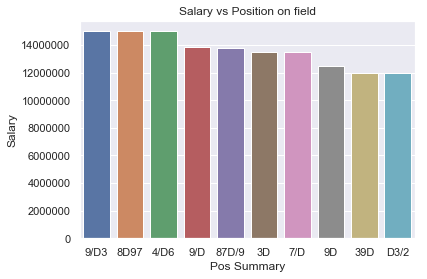

In [8]:
# group by on Position of play and get avg salary.
position_data = final_data.groupby('Pos Summary', as_index=False)['Salary'].mean().sort_values(by=['Salary'],ascending=False)
plt.ticklabel_format(style='plain', axis='y')
ax = sns.barplot(x="Pos Summary", y="Salary", data=position_data.head(10))
plt.title('Salary vs Position on field')

Text(0.5, 1.0, 'Salary vs Team')

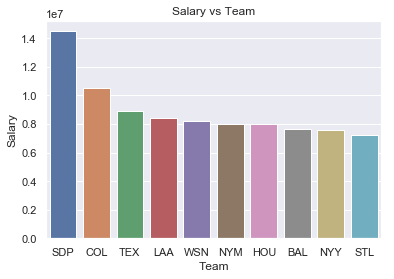

In [9]:
# group by on team name and get avg salary.\
state_data = final_data.groupby('Team', as_index=False)['Salary'].mean().sort_values(by='Salary',ascending=False)

ax = sns.barplot(x="Team", y="Salary", data=state_data.head(10))
plt.title('Salary vs Team')

Text(0.5, 1.0, 'Salary vs Year')

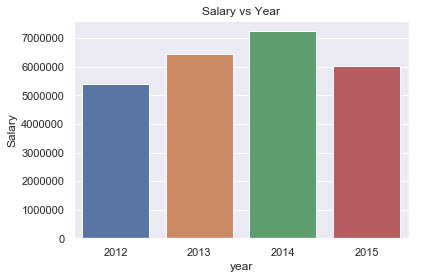

In [10]:
# group by on year of transfer of the player and get avg salary.
state_data = final_data.groupby('year', as_index=False)['Salary'].mean().sort_values(by='Salary',ascending=False)

ax = sns.barplot(x="year", y="Salary", data=state_data.head(10))
plt.title('Salary vs Year')

Text(0.5, 1.0, 'Salary vs State')

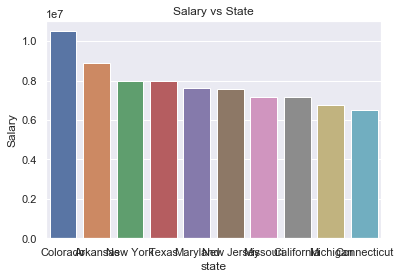

In [11]:
# group by on State of team for which a player plays and get avg salary.\

state_data = final_data.groupby('state', as_index=False)['Salary'].mean().sort_values(by='Salary',ascending=False)

ax = sns.barplot(x="state", y="Salary", data=state_data.head(10))
plt.title('Salary vs State')

The categorical variables showed above has gradual difference in Salary across them, lets look at some Continuous variables as see if there exists some trend. For this lets plot regression plot to show trend with increasing salary.
We'll plot Salary with ages, WAR and Games played all of which shows upward trend. However, WAR which is the performance statistics shows highest gradient among all.

C:\Users\shivraj\Anaconda3\envs\project\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Salary vs Age')

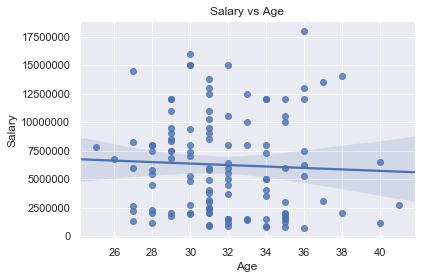

In [12]:
ax = sns.regplot(x="Age", y="Salary", data=final_data)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Salary vs Age')

Lets plot the performance variable ```WAR``` which is defined as ```This is the win-loss of an otherwise average team in ONLY the games this player played in``` which shows the highest gradient among all variables when it comes to regress against Salary. This plot is acceptable as this shows how performance remains the influential criteria when it comes to Salary.

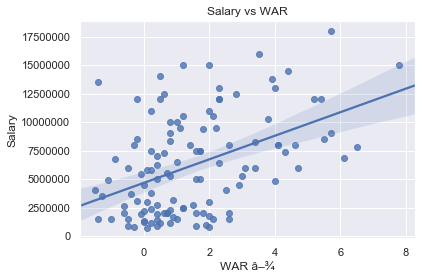

In [13]:
ax = sns.regplot(x="WAR â–¾", y="Salary", data=final_data)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Salary vs WAR')
fig = ax.get_figure()

A simple regression plot of Salary with Games_played shows an increasing trend for players with higher games recieving higher salaries,
which seems intuitive to me as players gets paid for their experience. 

Text(0.5, 1.0, 'Salary vs Games_played')

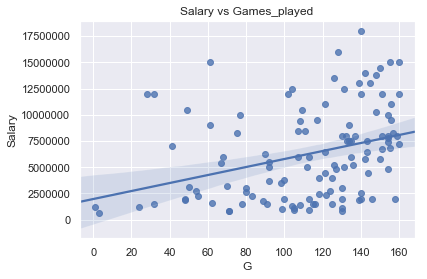

In [14]:
ax = sns.regplot(x="G", y="Salary", data=final_data)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Salary vs Games_played')

Finally lets see if there exists a difference in avg salary among whites and non-whites. It seems the avg salary is quite similar.

Text(0.5, 1.0, 'Salary vs Race')

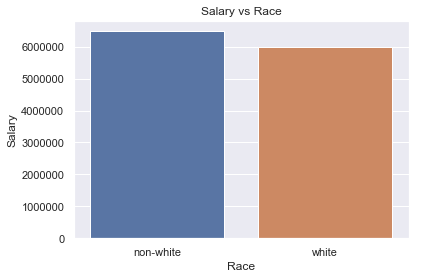

In [15]:
race_salary_data = final_data.groupby('Race', as_index=False)['Salary'].mean()
ax = sns.barplot(x="Race", y="Salary", data=race_salary_data)
plt.title('Salary vs Race')

## RQ1: What are the most significant factors in determining a players wage in MLB.

To Answer the research question around the most important variables in determining wages we'll create a decision tree based model using Lightgbm library and try to analyze the variable importance plot to see relative importance of variable which building a regression model on logarithm of wages(we use log to scale variable down).
Fo this First we will build a model including performance statistics of a player and another one excluding them, this would help us infer better as to how ```Race``` variable's relative impotance changes based on different covariates.

### Modelling Building using Lightgbm

Since tree based model needs just Numeric variables to make decision splits, we will ```LabelEncode``` the catrgorical features
``` ['Acquired','Pos Summary', 'Team','Race','state']```. We will drop variables with high cardinality like ```Name``` which can bias a decision tree model as decision tree splits are vulnerable to higher cardinality. We will also perform scaling of numerical variables with higher range in order to bring all variables to the same scale. Post this we will build a validation set and will benchmark our models performance on this validation set.

First Lets now run the model with  all performance statistics variables provided by baseball-reference which are : ```['Rbat', 'Rbaser', 'Rdp', 'Rfield', 'Rpos','RAA', 'WAA', 'Rrep', 'RAR','waaWL%', '162WL%', 'oWAR','dWAR', 'oRAR']```. A detailed explaination about these variables can be found in the ```Readme``` section.


Encode Variables
Encoding : ['Acquired', 'Pos Summary', 'Team', 'Race', 'state']
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[65]	train's l1: 0.542871	valid's l1: 0.640261
mae: 0.6402608070326378


C:\Users\shivraj\Anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\shivraj\Anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\shivraj\Anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


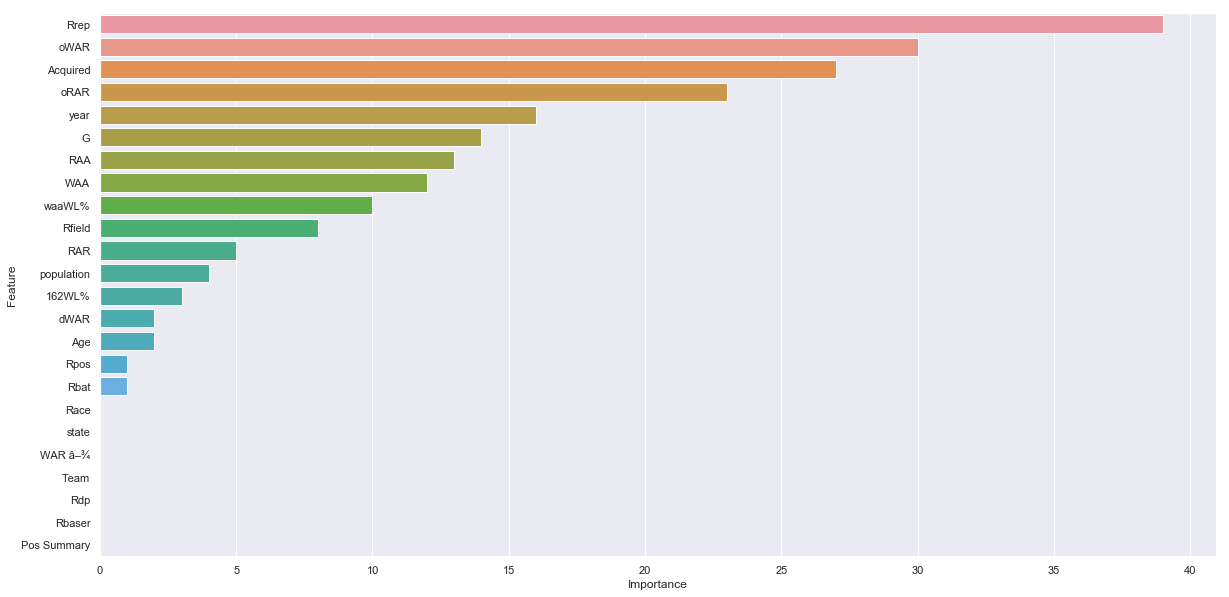

In [16]:
# Prepare data
final_data_model = final_data.copy()
# using pre-defined tree parameters which works best in most of the cases.
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mean_absolute_error',
    'max_depth': 10,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.9,
    'learning_rate': 0.016,
    'verbose': 0
}  

print("\nEncode Variables")
categorical = ['Acquired','Pos Summary', 'Team','Race','state']
print("Encoding :",categorical)
final_data_model = final_data.copy()

# Label Encoder:
label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    final_data_model[col] = final_data_model[col].astype(str)
    final_data_model[col] = label_encoder.fit_transform(final_data_model[col].astype(str))   
    
#selecting variables as features for the model
X = final_data_model.drop(['Name', 'Salary','PA'], axis=1)

# separating target variable, we will convert to log scale owing to large scale of the variable.
y = np.log(final_data_model['Salary'].values)

#scaling all numeric variables to same scale for consistency.
scaler = MinMaxScaler()
num_cols = X.columns[X.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
# ref: https://stackoverflow.com/questions/48673402/how-can-i-standardize-only-numeric-variables-in-an-sklearn-pipeline
num_cols = ['Age','G','WAR â–¾']
X[num_cols] = scaler.fit_transform(X[num_cols])

#preparing validation data for model performance
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=2019)

#converting data to lightgbm's expected data format which is matrix.
d_train = lgb.Dataset(x_train, label=y_train,categorical_feature = categorical)
d_valid = lgb.Dataset(x_valid, label=y_valid,categorical_feature = categorical)
watchlist = [d_valid]

#model training
lgb_model_with_performance = lgb.train(
    lgbm_params,
    d_train,
    num_boost_round=20000,
    valid_sets=[d_train, d_valid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=500
)

#making predictions
preds = lgb_model_with_performance.predict(x_valid)

#computing error, mean absolute error
err = metrics.mean_absolute_error(y_valid, preds)
print('mae:', err)
feature_imp = pd.DataFrame(sorted(zip(lgb_model_with_performance.feature_importance(),x_train.columns)), columns=['Importance','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Feature", data=feature_imp.sort_values(by="Importance", ascending=False))

First Lets now run the same model without the performance statistics variables provided by baseball-reference which are : ```['Rbat', 'Rbaser', 'Rdp', 'Rfield', 'Rpos','RAA', 'WAA', 'Rrep', 'RAR','waaWL%', '162WL%', 'oWAR','dWAR', 'oRAR']```. We do this to see if Race still remain a insignificant variable in determining wages.

In [17]:
# Prepare data
final_data['Age'] = final_data['Age'].astype(int)
final_data_model = final_data.copy()
# using pre-defined tree parameters which works best in most of the cases.
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mean_absolute_error',
    'max_depth': 12,
    'feature_fraction': 0.95,
    'bagging_fraction': 0.9,
    'learning_rate': 0.016,
    'verbose': 0
}  

print("\nEncode Variables")
categorical = ['Acquired','Pos Summary', 'Team','Race','state']
print("Encoding :",categorical)
final_data_model = final_data.copy()

# Label Encoder:
label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    final_data_model[col] = final_data_model[col].astype(str)
    final_data_model[col] = label_encoder.fit_transform(final_data_model[col].astype(str))   
    
#selecting variables as features for the model
X = final_data_model.drop(['Name', 'Salary','Rbat', 'Rbaser', 'Rdp', 'Rfield', 'Rpos',
       'RAA', 'WAA', 'Rrep', 'RAR','waaWL%', '162WL%', 'oWAR',
       'dWAR', 'oRAR','population','PA','year'], axis=1)

# separating target variable, we will convert to log scale owing to large scale of the variable.
y = np.log(final_data_model['Salary'].values)

#scaling all numeric variables to same scale for consistency.
scaler = MinMaxScaler()
num_cols = X.columns[X.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
num_cols = ['Age','G','WAR â–¾']
X[num_cols] = scaler.fit_transform(X[num_cols])

#preparing validation data for model performance
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=2019)

#converting data to lightgbm's expected data format which is matrix.
d_train = lgb.Dataset(x_train, label=y_train,categorical_feature = categorical)
d_valid = lgb.Dataset(x_valid, label=y_valid,categorical_feature = categorical)
watchlist = [d_valid]

#model training
lgb_model_non_performance = lgb.train(
    lgbm_params,
    d_train,
    num_boost_round=20000,
    valid_sets=[d_train, d_valid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=500
)

#making predictions
preds = lgb_model_non_performance.predict(x_valid)

#computing error, mean absolute error
err = metrics.mean_absolute_error(y_valid, preds)
print('mae:', err)


Encode Variables
Encoding : ['Acquired', 'Pos Summary', 'Team', 'Race', 'state']
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[275]	train's l1: 0.47715	valid's l1: 0.559893
mae: 0.5598928771255993


C:\Users\shivraj\Anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\shivraj\Anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\shivraj\Anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


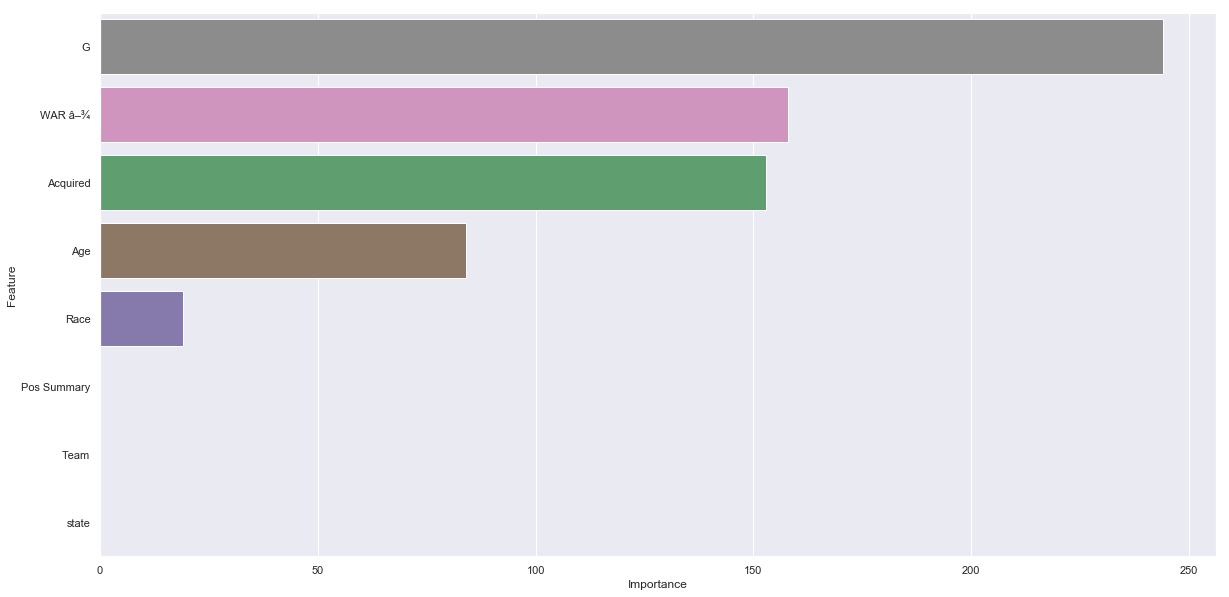

In [18]:
color_mapping = {"Pos Summary" : "C0", "state" : "C1", "Acquired" : "C2", "Team" : "C3", "Race" : "C4", "Age": "C5","WAR â–¾": "C6",
                "G":"C7"}
feature_imp = pd.DataFrame(sorted(zip(lgb_model_non_performance.feature_importance(),x_train.columns)), columns=['Importance','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Feature", data=feature_imp.sort_values(by="Importance", ascending=False), palette=color_mapping)

Based on the Two variable importance plot we can see that Race is Not coming as a significant variable when compared to others in determining wages. More importantly performance statitsics variables are coming important that wages which is good to see as this reinforces the idea that performance is more important than Race in determining wages.

### RQ:2 Consistency across various model with same performance.

Having see the variable importance plot which is quite helpful in determining the variables significance in analyzing which ar more significant than others in explaining the variance in ```wages``` for a player and since decision trees are widely used as inference based models, my next research question is around how consistent these decision tree based models are. For this i would be using the same validation data as above and train two additional ```xgboost``` and ```random forest``` based model and check how variable importance plot looks for these two model run. In order to compare equivalent model, I have optimized the hyperparameters to make the ```Mean absolute error``` of these models comparable to one of the ```lightgbm``` model trained above this way we can compare apples to apples.

### Random Forest model

mae: 0.5668383210639013


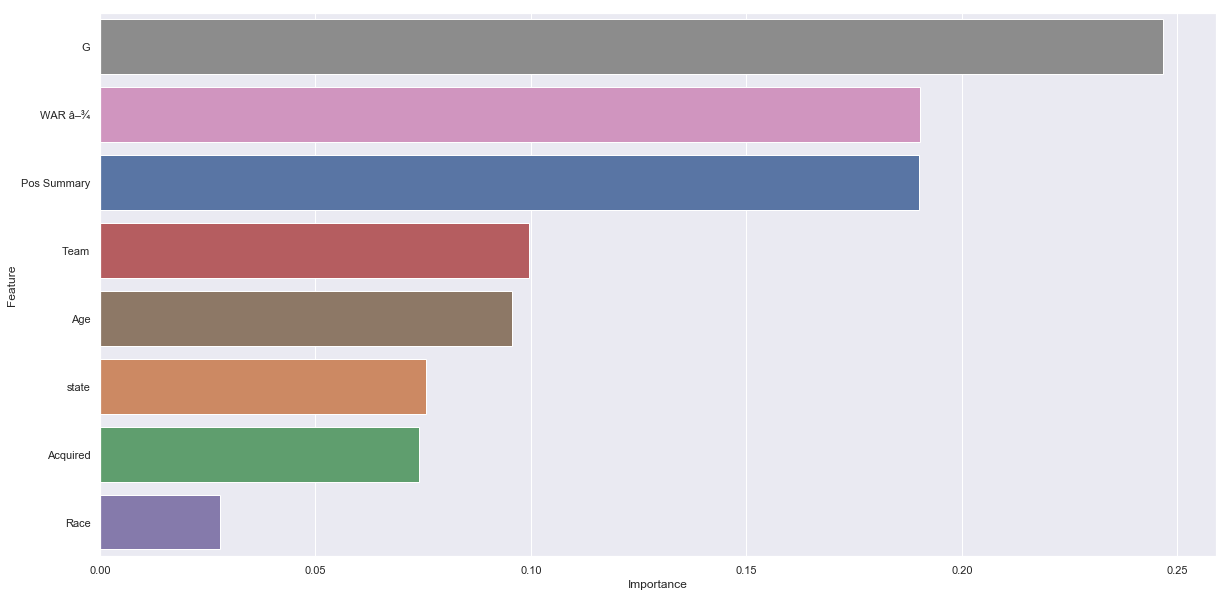

In [19]:
#build a random forest model
random_forest = RandomForestRegressor(random_state=42,n_estimators = 100, max_features = 'sqrt',max_depth=10)

random_forest.fit(x_train,y_train)
preds = random_forest.predict(x_valid)
err = metrics.mean_absolute_error(y_valid, preds)
print('mae:', err)
#https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
feature_imp = pd.DataFrame(sorted(zip(random_forest.feature_importances_,x_train.columns)), columns=['Importance','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Feature", data=feature_imp.sort_values(by="Importance", ascending=False),palette=color_mapping)

 ### xgboost

In [20]:
%%capture
#define xgboost tree parameters
xgb_params =  {
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 12,
    'eta': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'learning_rate': 0.016,
    'verbose': 0
}  

#build data matrix for xgboost algo
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

xgb_model = xgb.train(
    xgb_params,
    d_train,
    20000,
    watchlist,
    early_stopping_rounds=50,
    verbose_eval=0
)

mae: 0.6039541872072535


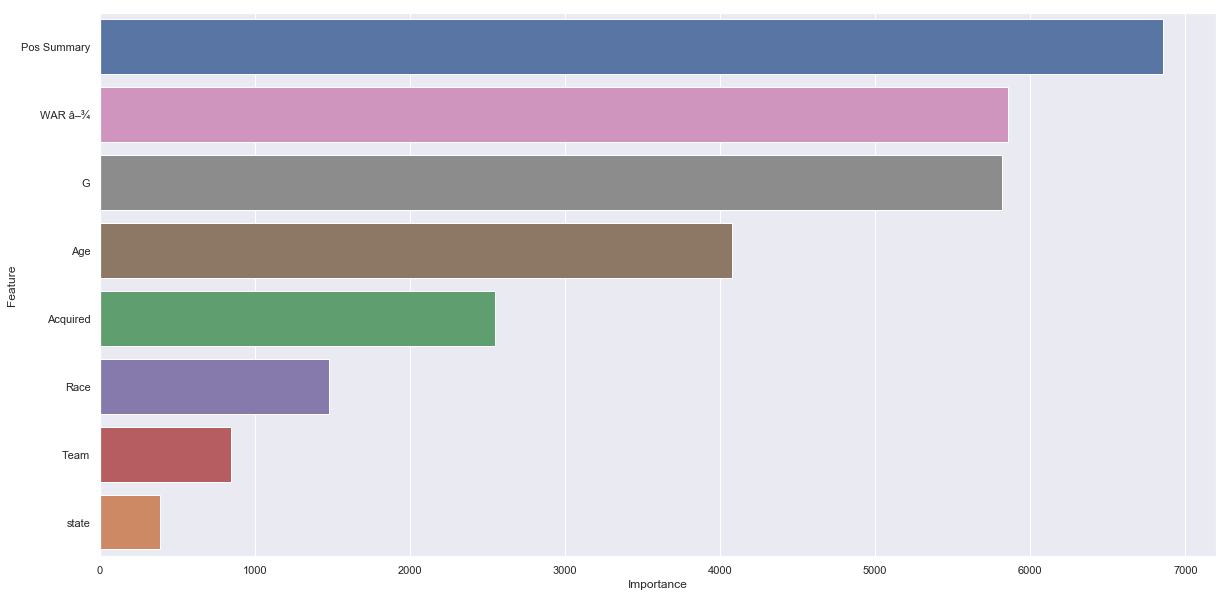

In [21]:
preds = xgb_model.predict(d_valid)

err = metrics.mean_absolute_error(y_valid, preds)
print('mae:', err)
feature_imp = pd.DataFrame(sorted(zip(list(xgb_model.get_score(importance_type='weight').values()),x_train.columns)), columns=['Importance','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Feature", data=feature_imp.sort_values(by="Importance", ascending=False),palette=color_mapping)

As we can see all three decision tree based model had similar scores but had varying variable importance plot.

The Performance table shown below shows very similar perfromance for all three models, which is what is being optimized in various machine learning pipelines.

| Model         | Performance(MAE)   |
|---------------|--------------------|
| Lightgbm      | 0.55  |
| Xgboost       | 0.59  |
| Random Forest | 0.56  |


However as we can see from the variable importance plot generated above varies alot between models.
For ```Lightgbm``` : ```[Games played, WAR and Acquired]``` are top features
For ```Xgboost``` : ```[Position, Age, Games played]``` are top features
For ```Random Forest``` : ```[Games played, WAR, Position]``` are top features.

Thus even for limited number of features(8 in our case) there is not much consistency as to which variable is more significant in making inferences around ```wages```. Thus inference based just on one model is not actaully correct and one might need to run multiple runs of different model architecture to make any inferences.

# Data Limitations / Limitations of Analysis

## Future Work

Having read about and intrigued by the application and success of Mixed models in Data science, I would be looking to extend the current work to a more mixed method approach. Though the work presented above covers the quantitative aspect of the analysis I am  particulalry interested in extending this and incorporating the qualitative analysis by doing  market research and including stakeholders with better domain knowledge.
A very informative discussion during the presentation that was brought up was how ```Games played``` consistently came important across various model run and how this variable is affected by ```Race``` variable i.e Race might decide who gets to play more games, thus future work would involve analyzing this causal and effect analysis of this aspect of analysis which was not considered here.

Additionally the Race data is incomplete and is not avalibale for lot of players thus extending the data-set would also be a step forward towards a more elaborate and conclusive analysis.


# Conclusion

My conclusions around two research question are:

***RQ1 : Players performance statistics is more important than Race in determining wages. ***

***RQ2 : Interpretability across similar performing Algorithms is not consistent. ***

**RQ1**: Based on the two variable importance plots one including Players performance statistics and one exluding the performance statistics we can see that ```Race``` didn't come up as most influential variable and thus we can infer that performance remains the more important measuring criteria in determining the players wage.

However following discussion and recieving feedback one important perspective that came out was that Number of games played remained consistently the most important variable across models and one source of bias than can be present in the data could be owing to Racial discrimination the games played by a non-white player might be less and thus this information might get consumed in model's inferences and thus just because a non-white was discriminated when it came to game time his there might exist a correlation between Race and Games played. Though this inference is speculation for now which needs further analysis. 

**RQ2**: My second research question was around how consistent are tree based models when it comes to providing inferences about important features for making predictions. Since I used 3 different tree models which have similar underlying boosting framework and are primarliy different in how they make decision splits so it was interesting to analyze if these tree based models with similar performance would yeild similar inferences ?

Since while building a machine learning model we are mostly interested in optimizing for loss function(in my case Mean absolute error), but it was interesting to see that all three tree based model produced different feature importance for same train and validation data and thus though these tree based models are touted as something that makes machine learning interpretible looking at the results I have questions around how consistent are these algorithms while making inferences about similar data with similar performance optimization.
In colclusion I would recommend building multiple tree based models and cross reference each of them before making final inference, as inference based on just one tree based models might not be conclusive enough.

# References
[1]https://www.usatoday.com/story/sports/mlb/2018/09/27/mlb-attendance-down-biggest-slide-decade/1441318002/

[2]https://www.statista.com/statistics/193421/regular-season-attendance-in-the-mlb-since-2006/

[3]https://www.forbes.com/sites/leighsteinberg/2018/04/17/why-have-african-american-players-disappeared-in-mlb/#40b67ff750df

[4]https://www.usnews.com/opinion/op-ed/articles/2017-07-10/3-reasons-for-the-declining-percentage-of-black-baseball-players-in-the-mlb

[5]https://www.fangraphs.com/tht/searching-for-racial-earnings-differentials-in-major-league-baseball/

[6]https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ZUMXXL

# Other Resources
https://www.rand.org/pubs/research_memoranda/RM6227.html

https://digitalcommons.iwu.edu/cgi/viewcontent.cgi?article=1022&context=econ_honproj